In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image

In [2]:
try:
    import google.colab
    from google.colab import drive

    !uv pip install anomalib
    !uv pip install open-clip-torch
    !uv pip install qwen-vl-utils
    !uv pip install transformers==4.52.4
    !uv pip install langchain-chroma langchain-huggingface

    drive.mount('/content/drive', force_remount=True)

    # Colab Root
    PROJECT_ROOT = Path('/content/drive/Othercomputers/Mac/multiModal_anomaly_report') # 본인 경로 수정: Mac/Window
    DATA_ROOT = PROJECT_ROOT / "dataset" / "MMAD"

except ImportError:

    # Local Root
    PROJECT_ROOT = Path.cwd().parents[1]
    DATA_ROOT = PROJECT_ROOT / "datasets" / "MMAD"

os.chdir(PROJECT_ROOT) # 현재 경로 수정
print(f"Current working directory: {os.getcwd()}")

Using Python 3.12.12 environment at: /usr
Audited 1 package in 100ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 96ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 94ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 95ms
Using Python 3.12.12 environment at: /usr
Audited 2 packages in 96ms
Mounted at /content/drive
Current working directory: /content/drive/Othercomputers/Mac/multiModal_anomaly_report


### Load Json

In [3]:
from src.utils import load_json

# Json path
DOMAIN_KNOWLEDGE_ROOT = DATA_ROOT / "domain_knowledge.json"

domain_knowledge = load_json(DOMAIN_KNOWLEDGE_ROOT)
target_datasets = ["GoodsAD", "MVTec-LOCO"]
knowledge = {k: v for k, v in domain_knowledge.items() if k in target_datasets}
knowledge['GoodsAD']['cigarette_box']

{'good': ' <Normal Characteristics>\n Description: The cigarette boxes displayed in the images exhibit standard characteristics for packaging in this product category. Each box maintains a consistent form and structure, featuring intact edges and corners without any visible tears, dents, or distortions. The color schemes are typically vibrant and aligned with brand specifications, incorporating decorative elements, logos, and text that are clear, sharp, and properly positioned. The design patterns are symmetrical and consistent across the various boxes, with no signs of misprinting or irregular graphics. Minor noise features such as reflections, shadows, and slight variations in color due to lighting conditions are present, but these do not detract from the overall quality and presentation of the boxes. The packaging appears well-preserved, suitable for retail display, and in line with expected standards for cigarette products.',
 'opened': ' <Packaging Tampering>\n Description: The de

In [ ]:
rows = []
for dataset, categories in knowledge.items():
    for category, defects in categories.items():
        for defect_type, desc in defects.items():
            rows.append({
                "dataset": dataset,
                "category": category,
                "defect_type": defect_type,
                "description": desc.strip(),
                "char_len": len(desc.strip()),
            })

df = pd.DataFrame(rows)
df

,dataset,category,defect_type,description,char_len
0,MVTec-LOCO,pushpins,good,<Normal Characteristics>\n Description: The pu...,847
1,MVTec-LOCO,pushpins,structural_anomalies,<Structural Anomaly>\n Description: The pushpi...,632
2,MVTec-LOCO,pushpins,logical_anomalies,<Logical Anomaly: Missing or Additional Pushpi...,1030
3,MVTec-LOCO,breakfast_box,good,<Normal Characteristics>\n Description: The br...,937
4,MVTec-LOCO,breakfast_box,structural_anomalies,<Fruit Damage and Contamination>\n Description...,828
5,MVTec-LOCO,breakfast_box,logical_anomalies,<Logical Anomalies>\n Description: The common ...,1069
6,MVTec-LOCO,screw_bag,good,<Normal Characteristics>\n Description: The in...,835
7,MVTec-LOCO,screw_bag,structural_anomalies,<Structural Anomaly>\n Description: The items ...,1196
8,MVTec-LOCO,screw_bag,logical_anomalies,<Logical Anomaly in Hardware Sets>\n Descripti...,1182
9,MVTec-LOCO,juice_bottle,good,<Normal Characteristics>\n Description: The in...,892


### Description length distribution

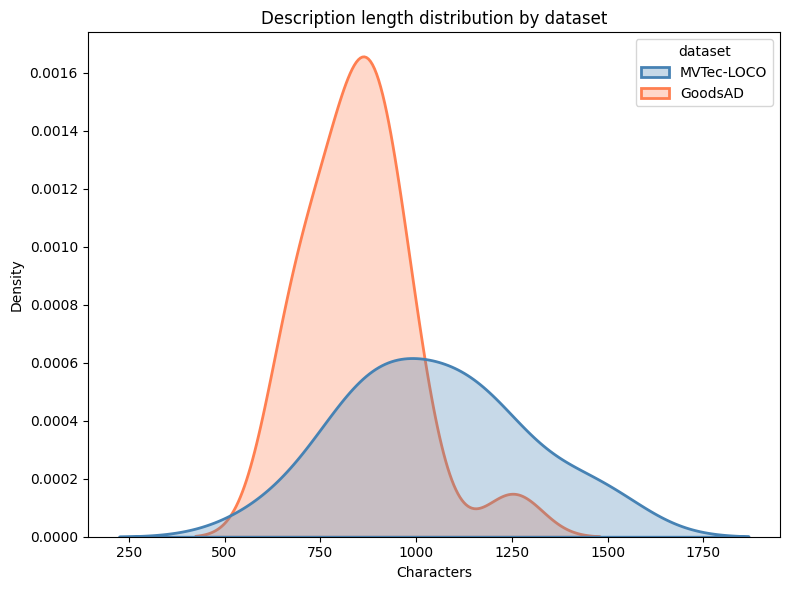

<Axes: title={'center': 'Description length distribution by dataset'}, xlabel='Characters', ylabel='Density'>

In [ ]:
from src.visual.plot import *

kde_plot(df, col="char_len", hue="dataset", figsize=(8, 6),
           title="Description length distribution by dataset",
           xlabel="Characters",
           palette=["steelblue", "coral"])

### Defect types Counts

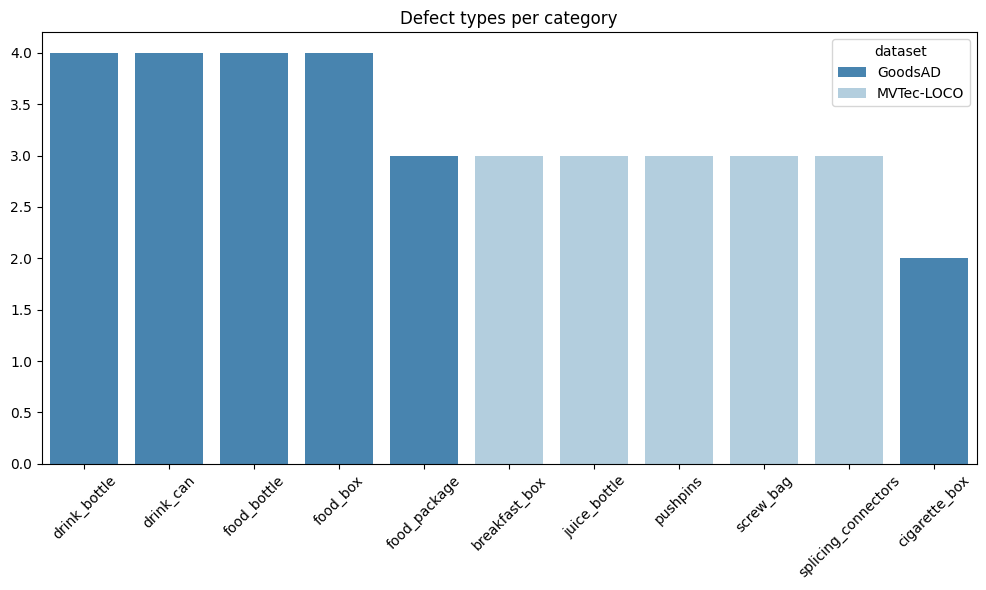

<Axes: title={'center': 'Defect types per category'}>

In [ ]:
defect_counts = df.groupby(["dataset", "category"])["defect_type"].count().reset_index(name="count")
defect_counts = defect_counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)
bar_plot(defect_counts, x_col="category", y_col="count", hue="dataset",
        title="Defect types per category", rotation=45)

/Users/mungughyeon/Documents/Bootcamp/Likelion/multiModal_anomaly_report/src/visual/plot.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=hue, y=col, palette=palette, ax=ax)


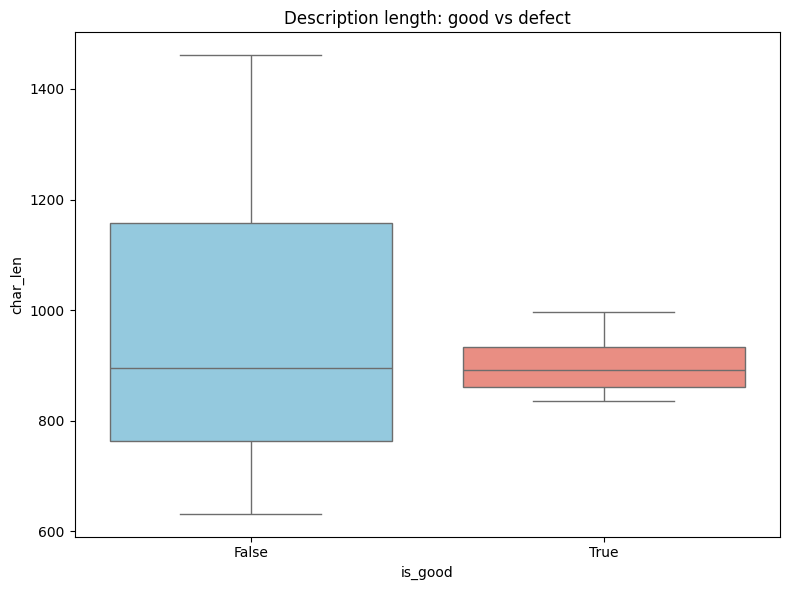

<Axes: title={'center': 'Description length: good vs defect'}, xlabel='is_good', ylabel='char_len'>

In [ ]:
df["is_good"] = df["defect_type"] == "good"
box_plot(df, col="char_len", hue="is_good",
        title="Description length: good vs defect")

In [ ]:
from src.rag import Indexer, Retrievers

indexer = Indexer(
    json_path=DOMAIN_KNOWLEDGE_ROOT,
    persist_dir="vectorstore/domain_knowledge",
    embedding_provider="huggingface",
)

vectorstore = indexer.get_or_create()
print(f"Documents indexed: {vectorstore._collection.count()}")

Documents indexed: 146


In [ ]:
retriever = Retrievers(vectorstore)

docs = retriever.retrieve("제품 표면에 긁힌 자국이 있고 색이 변했어요", dataset=["GoodsAD", "MVTec-LOCO"], k=3)
for doc in docs:
    print(doc.metadata)
    print(doc.page_content[:100], "\n")

{'dataset': 'GoodsAD', 'defect_type': 'opened', 'category': 'cigarette_box'}
<Packaging Tampering>
 Description: The defect involves an alteration in the packaging integrity of  

{'category': 'food_box', 'defect_type': 'surface_damage', 'dataset': 'GoodsAD'}
<Surface Damage>
 Description: The defect appears as a variety of surface irregularities found on th 

{'dataset': 'GoodsAD', 'defect_type': 'opened', 'category': 'food_bottle'}
<Compromised Seal/Opened Packaging>
 Description: The defect appears as an opening, tear, or irregul 



In [ ]:
docs = retriever.retrieve("포장 상자가 찌그러지고 모서리가 눌려있어요", dataset=["GoodsAD", "MVTec-LOCO"], k=3)
for doc in docs:
    print(doc.metadata)
    print(doc.page_content[:200], "\n")

{'dataset': 'GoodsAD', 'category': 'cigarette_box', 'defect_type': 'opened'}
<Packaging Tampering>
 Description: The defect involves an alteration in the packaging integrity of cigarette boxes, most notably at the top center where the packaging is supposed to be sealed. Visual 

{'category': 'food_bottle', 'dataset': 'GoodsAD', 'defect_type': 'opened'}
<Compromised Seal/Opened Packaging>
 Description: The defect appears as an opening, tear, or irregularity at the top center of cylindrical food containers, indicating that the seal has been broken or  

{'defect_type': 'cap_open', 'dataset': 'GoodsAD', 'category': 'drink_bottle'}
<Open Cap>
 Description: The defect involves the cap of the beverage bottle not being fully sealed or slightly ajar, as expected in a properly packaged product. This defect is typically located at the 



### RAG 전/후 MMAD QA 성능 비교

- `run_experiment.py`를 Baseline / RAG 두 번 실행 후 `compare_results.py`로 비교

In [5]:
# setting
LLM = "internvl3.5-2b"
MMAD_JSON = DATA_ROOT / "mmad_10classes.json"  # 또는 mmad_10classes.json
OUTPUT_DIR = f"output/mllm/{LLM}"
OUTPUT_RAG_ROOT = f"{OUTPUT_DIR}/rag"
SAMPLE_PER_FOLDER = 3  # 빠른 테스트: 폴더당 3장

In [5]:
# Baseline (RAG 없이)
!python scripts/run_experiment.py \
    --llm {LLM} \
    --ad-model null \
    --data-root {DATA_ROOT} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_DIR} \
    --mmad-json {MMAD_JSON} \
    --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
MMAD Experiment Runner
Experiment:  no_ad_internvl3.5-2b_1shot
LLM:         internvl3.5-2b
AD model:    none
RAG:         disabled
Few-shot:    1
Template:    Random_template
Image size:  (384, 384)
Images:      99 / 4224
Data root:   /content/drive/Othercomputers/Mac/multiModal_anomaly_report/dataset/MMAD
Output:      output/mllm/internvl3.5-2b/answers_1_shot_internvl3.5-2b_Random_template_99img.json

Filtered MMAD json: 99 images -> output/mllm/internvl3.5-2b/_sampled_mmad.json

Device: NVIDIA A100-SXM4-40GB
Evaluating:   0%|                                                            | 0/99 [00:00<?, ?it/s]A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL3_5-2B:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new versio

In [6]:
# With RAG
!python scripts/run_experiment.py \
    --llm {LLM} \
    --ad-model null \
    --rag \
    --data-root {DATA_ROOT} \
    --sample-per-folder {SAMPLE_PER_FOLDER} \
    --output-dir {OUTPUT_RAG_ROOT} \
    --mmad-json {MMAD_JSON} \
    --batch-mode true

Stratified sampling: 3장/폴더, 33폴더
  Total: 4224 -> Sampled: 99 (normal=30, anomaly=69)
2026-02-13 09:12:52.215470: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 09:12:52.233763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770973972.256848    9822 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770973972.264326    9822 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770973972.283636    9822 computation_placer.

In [7]:
# 결과 비교
!python scripts/compare_results.py --output-dir {OUTPUT_DIR} --sort accuracy

Experiment               LLM            AD Model       Few-shotAccuracyImages  ErrorsTime    Timestamp           
-----------------------------------------------------------------------------------------------------------------
no_ad_internvl3.5-2b_1sh internvl3.5-2b none           1       56.0%   99      0     421s    2026-02-13T18:01:26 

Total experiments: 1
Best accuracy: 56.0% (no_ad_internvl3.5-2b_1shot)


In [ ]:
# 4) 상세 비교 시각화
from pathlib import Path
import json

# .meta.json 파일에서 결과 로드
meta_files = sorted(Path(OUTPUT_DIR).glob("*.meta.json"))
results = []
for f in meta_files:
    with open(f) as fp:
        meta = json.load(fp)
        results.append(meta)

# Baseline vs RAG 필터
baseline = [r for r in results if not r.get("rag", False) and LLM.replace(".", "_") in r.get("experiment_name", "")]
rag = [r for r in results if r.get("rag", False) and LLM.replace(".", "_") in r.get("experiment_name", "")]

if baseline and rag:
    bl = baseline[-1]  # 가장 최근
    rg = rag[-1]

    print("=" * 60)
    print(f"{'':>20} {'Baseline':>12} {'With RAG':>12} {'Diff':>10}")
    print("=" * 60)

    bl_acc = bl.get("accuracy", 0)
    rg_acc = rg.get("accuracy", 0)
    diff = rg_acc - bl_acc
    arrow = "+" if diff > 0 else ""
    print(f"{'Accuracy (%)':>20} {bl_acc:>12.2f} {rg_acc:>12.2f} {arrow}{diff:>9.2f}")

    print(f"{'Total Questions':>20} {bl.get('total_questions', 0):>12} {rg.get('total_questions', 0):>12}")
    print(f"{'Correct':>20} {bl.get('total_correct', 0):>12} {rg.get('total_correct', 0):>12}")
    print(f"{'Errors':>20} {bl.get('errors', 0):>12} {rg.get('errors', 0):>12}")
    print(f"{'Time (s)':>20} {bl.get('elapsed_seconds', 0):>12.1f} {rg.get('elapsed_seconds', 0):>12.1f}")
    print("=" * 60)
else:
    print("Baseline 또는 RAG 결과를 찾을 수 없습니다.")
    print(f"발견된 meta 파일: {[f.name for f in meta_files]}")